# Implimeting ML model into trade strategy

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from ta import momentum, volatility, trend
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
from sklearn.utils import resample
from xgboost import XGBClassifier

In [3]:
import asyncio
import os
import pandas as pd
import numpy as np
from dotenv import load_dotenv
from alpaca.data.live import StockDataStream
from alpaca.trading.client import TradingClient
from alpaca.trading.requests import MarketOrderRequest
from alpaca.trading.enums import OrderSide, TimeInForce
from alpaca.data.enums import DataFeed
from alpaca.data.timeframe import TimeFrame
import matplotlib.pyplot as plt
from datetime import datetime
from alpaca.data.historical import StockHistoricalDataClient
from alpaca.data.requests import StockBarsRequest

# Load environment variables
load_dotenv()  # Load .env file

API_KEY = os.getenv("ALPACA_API_KEY")
API_SECRET = os.getenv("ALPACA_SECRET_KEY")

# Initialize TradingClient
Trading_Client = TradingClient(API_KEY, API_SECRET, paper=True)  # paper=True for paper trading
data_client = StockHistoricalDataClient(API_KEY, API_SECRET)
SYMBOL = "MSFT"

Fetching historical data for MSFT...
Generating features...
Labeling data based on future returns...

Label distribution after labeling:
label
0.0    88956
1.0    63818
Name: count, dtype: int64
Training XGBoost with scale_pos_weight=1.39...


C:\Users\audri\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:58:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== Classification Report (Threshold = 0.5) ===
              precision    recall  f1-score   support

         0.0       0.60      0.59      0.59     26766
         1.0       0.43      0.44      0.44     19067

    accuracy                           0.53     45833
   macro avg       0.52      0.52      0.52     45833
weighted avg       0.53      0.53      0.53     45833


Confusion Matrix:
[[15858 10908]
 [10702  8365]]


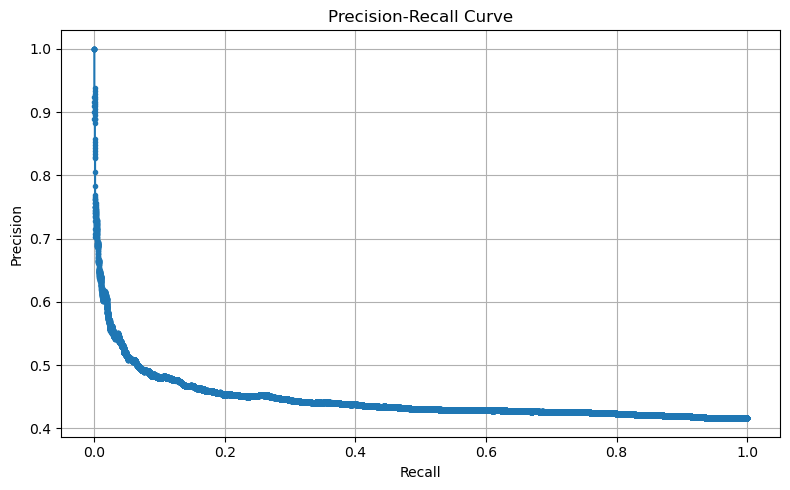


=== Feature Importances ===
sma_slope: 0.0989
vol_rolling: 0.0801
atr_ratio: 0.0760
atr: 0.0750
volatility: 0.0738
macd_diff: 0.0663
rsi: 0.0640
macd_diff_lag1: 0.0610
rsi_lag3: 0.0597
rsi_lag2: 0.0597
rsi_lag1: 0.0592
macd_diff_lag3: 0.0581
macd_diff_lag2: 0.0571
trend_num: 0.0565
volume_spike: 0.0545

Saved predictions to ml_predictions.csv


In [20]:
LOOKAHEAD_BARS = 30
RETURN_THRESHOLD = 0.0005
CUSTOM_THRESHOLD = 0.5  # adjust between 0.5 and 0.95

# === Step 1: Fetch Historical Data ===
print(f"Fetching historical data for {SYMBOL}...")
data_client = StockHistoricalDataClient(API_KEY, API_SECRET)
request = StockBarsRequest(
    symbol_or_symbols=[SYMBOL],
    timeframe=TimeFrame.Minute,
    start=datetime(2024, 1, 1),
    end=datetime(2024, 12, 30),
    adjustment='all'
)
bars = data_client.get_stock_bars(request).df

# === Step 2: Clean and Prepare DataFrame ===
if isinstance(bars.index, pd.MultiIndex):
    df = bars.xs(SYMBOL, level='symbol').reset_index()
else:
    df = bars.reset_index()

df['timestamp'] = pd.to_datetime(df['timestamp'])
df['date'] = df['timestamp'].dt.date

# === Step 3: Feature Engineering ===
print("Generating features...")
df['rsi'] = momentum.RSIIndicator(df['close'], window=14).rsi()
df['atr'] = volatility.AverageTrueRange(df['high'], df['low'], df['close'], window=14).average_true_range()
df['macd_diff'] = trend.MACD(df['close']).macd_diff()
df['vol_rolling'] = df['volume'].rolling(30).mean()
df['atr_ratio'] = df['atr'] / df['close']

df['daily_close'] = df.groupby('date')['close'].transform('last')
df['sma_trend'] = df['daily_close'].rolling(20).mean()
df['daily_trend'] = np.where(df['daily_close'] > df['sma_trend'], 'up', 'down')
df['trend_num'] = df['daily_trend'].map({'up': 1, 'down': -1})

# Advanced features
df['returns'] = df['close'].pct_change()
df['volatility'] = df['returns'].rolling(20).std()
df['volume_spike'] = df['volume'] / df['volume'].rolling(20).mean()
df['sma_slope'] = df['sma_trend'].diff()

for lag in range(1, 4):
    df[f'rsi_lag{lag}'] = df['rsi'].shift(lag)
    df[f'macd_diff_lag{lag}'] = df['macd_diff'].shift(lag)

# === Step 4: Label Generation Based on Future Returns ===
def generate_labels_by_future_return(df, lookahead=30, threshold=0.01):
    labels = []
    for i in range(len(df) - lookahead):
        future_return = (df['close'].iloc[i + lookahead] - df['close'].iloc[i]) / df['close'].iloc[i]
        labels.append(1 if future_return >= threshold else 0)
    labels += [np.nan] * lookahead
    return pd.Series(labels, index=df.index)

print("Labeling data based on future returns...")
df['label'] = generate_labels_by_future_return(df, lookahead=LOOKAHEAD_BARS, threshold=RETURN_THRESHOLD)

# === Step 5: Prepare Training Data ===
features = [
    'rsi', 'macd_diff', 'vol_rolling', 'atr', 'atr_ratio', 'trend_num',
    'volatility', 'volume_spike', 'sma_slope',
    'rsi_lag1', 'rsi_lag2', 'rsi_lag3',
    'macd_diff_lag1', 'macd_diff_lag2', 'macd_diff_lag3'
]

df = df.dropna(subset=features + ['label'])
X = df[features]
y = df['label']

print("\nLabel distribution after labeling:")
print(y.value_counts())

# === Step 6: Train/Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

# === Step 7: Train Model with Class Weighting ===
pos_weight = (len(y_train) - sum(y_train)) / sum(y_train)

print(f"Training XGBoost with scale_pos_weight={pos_weight:.2f}...")

model = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=pos_weight,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

model.fit(X_train, y_train)

# === Step 8: Prediction with Thresholding ===
probs = model.predict_proba(X_test)[:, 1]
y_pred_thresh = (probs > CUSTOM_THRESHOLD).astype(int)

# === Step 9: Evaluation ===
print(f"\n=== Classification Report (Threshold = {CUSTOM_THRESHOLD}) ===")
print(classification_report(y_test, y_pred_thresh, zero_division=0))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_thresh))

# === Step 10: Precision-Recall Curve ===
precision, recall, thresholds = precision_recall_curve(y_test, probs)

plt.figure(figsize=(8, 5))
plt.plot(recall, precision, marker='.')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.tight_layout()
plt.show()

# === Step 11: Feature Importance ===
print("\n=== Feature Importances ===")
importances = model.feature_importances_
for feat, imp in sorted(zip(features, importances), key=lambda x: x[1], reverse=True):
    print(f"{feat}: {imp:.4f}")

# === Step 12: Save Prediction Output ===
df.loc[X_test.index, 'predicted_label'] = y_pred_thresh
df.loc[X_test.index, 'predicted_prob'] = probs
df[['timestamp', 'close', 'label', 'predicted_label', 'predicted_prob']].to_csv("ml_predictions.csv", index=False)

print("\nSaved predictions to ml_predictions.csv")